Load/format data, do any necessary preprocessing and EDA in this notebook.

In [1]:
%matplotlib inline

import glob
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import os

def paths_to_datetimeindex(paths):
    """
    Extract the FIRST date from each filename and return a pandas.DatetimeIndex.
    string_slice should give the full date range substring.
    Example substring: '20190606-20190622'
    """
    labels = []
    for p in paths:
        fname = p.split('/')[-1]
        dates = re.findall(r"\d{8}", fname)
        if len(dates) < 2:
            raise ValueError(f"File does not contain two dates: {fname}")
        start = pd.to_datetime(dates[0]).strftime("%Y-%m-%d")
        end = pd.to_datetime(dates[1]).strftime("%Y-%m-%d")
        labels.append(f"{start} - {end}")
    return labels

def midpoint(t):
    nums = re.findall(r"\d{4}\d{2}\d{2}", t.replace("-", ""))
    
    if len(nums) == 2:
        d1 = pd.to_datetime(nums[0])
        d2 = pd.to_datetime(nums[1])
        return d1 + (d2 - d1) / 2
    else:
        return pd.NaT

In [3]:
#requires: conda install -c conda-forge earthaccess

import earthaccess

earthaccess.login()

#username=pgandhi password=Karakoram3456*

In [4]:
granules = earthaccess.search_data(
    short_name="NSIDC-0801",
    doi='10.5067/VHFVXHZHOO6P'
)

MZ_results = granules[0]
SR_results = granules[1:3]
SK_results = granules[3]
AV_results = granules[4]
LO_results = granules[5]

Granules found: 6


where:  
MZ = Medvezhiy Glacier in Tajikstan  
**SR = South Rimo Glacier in Karakoram(Pakistan)**  
SK = Sít' Kusá Glacier in Alaska  
AV = Aavatsmarkbreen Glacier in Norway  
LO = Nàłùdäy/Lowell Glacier in Canada

In [5]:
os.makedirs("data/Karakoram", exist_ok=True)
SK_files=earthaccess.download(SR_results, local_path='data/Karakoram')

 Getting 2 granules, approx download size: 0.25 GB


QUEUEING TASKS | :   0%|          | 0/319 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/319 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/319 [00:00<?, ?it/s]

In [6]:
geotiff_list = geotiff_list = glob.glob("data/Karakoram/*_vm_*.tif")

# Create variable used for time axis
time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list))

# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat(
    [rioxarray.open_rasterio(i) for i in geotiff_list],
    dim=time_var
)

# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'x_vel', 2: 'y_vel', 3: 'vel_magnitude'})

#Adding midpoint time for sorting
mid_times = [midpoint(t) for t in geotiffs_ds.time.values]
geotiffs_ds = geotiffs_ds.assign_coords(mid_time=("time", mid_times))
geotiffs_ds = geotiffs_ds.sortby("mid_time")

# Print the output
geotiffs_ds

<xarray.Dataset> Size: 265MB
Dimensions:        (time: 308, y: 231, x: 310)
Coordinates:
  * x              (x) float64 2kB 7.11e+05 7.111e+05 ... 7.418e+05 7.419e+05
  * y              (y) float64 2kB 3.924e+06 3.924e+06 ... 3.902e+06 3.901e+06
    spatial_ref    int64 8B 0
  * time           (time) <U23 28kB '2019-03-18 - 2019-04-03' ... '2022-12-23...
    mid_time       (time) datetime64[ns] 2kB 2019-03-26 ... 2022-12-27
Data variables:
    x_vel          (time, y, x) float32 88MB nan nan nan nan ... nan nan nan nan
    y_vel          (time, y, x) float32 88MB nan nan nan nan ... nan nan nan nan
    vel_magnitude  (time, y, x) float32 88MB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

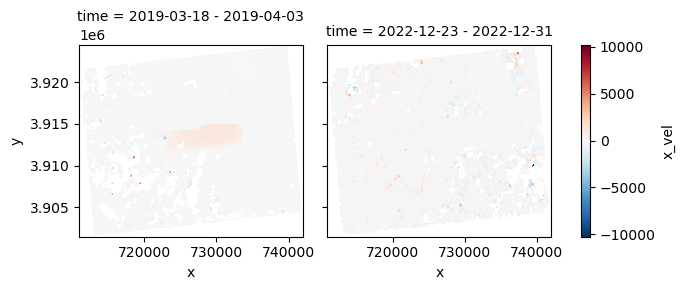

In [7]:
subset = geotiffs_ds.isel(time=[0, -1])
subset.x_vel.plot(col="time")

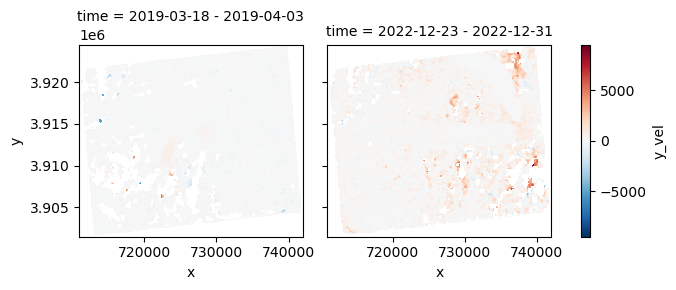

In [8]:
subset.y_vel.plot(col="time")

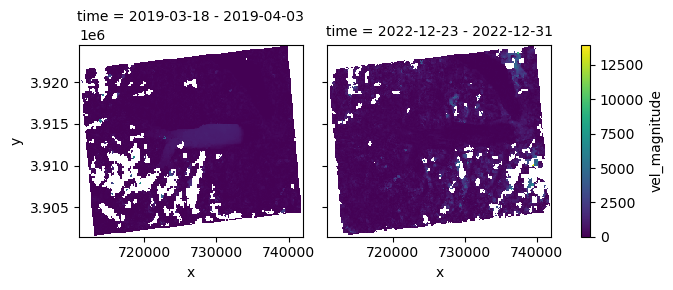

In [9]:
subset.vel_magnitude.plot(col="time")

In [10]:
for var in geotiffs_ds.data_vars:
    non_nan_count = geotiffs_ds[var].count().values
    total_count = geotiffs_ds[var].size
    print(f"{var}: {non_nan_count} / {total_count} non-NaN values")

x_vel: 11688945 / 22055880 non-NaN values
y_vel: 11688945 / 22055880 non-NaN values
vel_magnitude: 11688945 / 22055880 non-NaN values


About half of the coordinates have no data on average

In [11]:
print("Overall Velocities' Summary Statistics")

for var in geotiffs_ds.data_vars:
    print(var)
    print("min:", geotiffs_ds[var].min().values)
    print("max:", geotiffs_ds[var].max().values)
    print("mean:", geotiffs_ds[var].mean().values)
    print("median:", geotiffs_ds[var].median().values)
    print()

Overall Velocities' Summary Statistics
x_vel
min: -13131.745
max: 11872.678
mean: 23.944157
median: 5.3466797

y_vel
min: -12108.265
max: 11167.795
mean: -0.79392564
median: 0.0

vel_magnitude
min: 0.0
max: 17070.92
mean: 413.6919
median: 252.4881



In [12]:
mean_vx = geotiffs_ds.x_vel.mean(dim=['x','y'])
mean_vy = geotiffs_ds.y_vel.mean(dim=['x','y'])
mean_speed = geotiffs_ds.vel_magnitude.mean(dim=['x','y'])

summary_df = pd.DataFrame({
    'time': geotiffs_ds.time.values,
    'midpoint' : geotiffs_ds.mid_time.values,
    'mean_vx': mean_vx.values,
    'mean_vy': mean_vy.values,
    'mean_vel_magnitude': mean_speed.values})
summary_df

,time,midpoint,mean_vx,mean_vy,mean_vel_magnitude
0,2019-03-18 - 2019-04-03,2019-03-26,31.070816,-27.238939,158.897003
1,2019-04-03 - 2019-04-19,2019-04-11,35.301289,12.930854,141.212631
2,2019-04-19 - 2019-05-21,2019-05-05,108.520485,-29.038946,154.400253
3,2019-05-21 - 2019-06-06,2019-05-29,28.561535,-14.863124,186.832336
4,2019-06-06 - 2019-06-22,2019-06-14,35.434811,25.728876,262.479065
...,...,...,...,...,...
303,2022-11-05 - 2022-11-21,2022-11-13,2.037294,90.189659,212.438690
304,2022-11-21 - 2022-12-07,2022-11-29,-1.369489,-33.420937,187.553986
305,2022-12-07 - 2022-12-15,2022-12-11,-43.002960,46.769650,279.074493
306,2022-12-15 - 2022-12-23,2022-12-19,47.730019,-138.218842,302.679718


^Time Series Data 👀

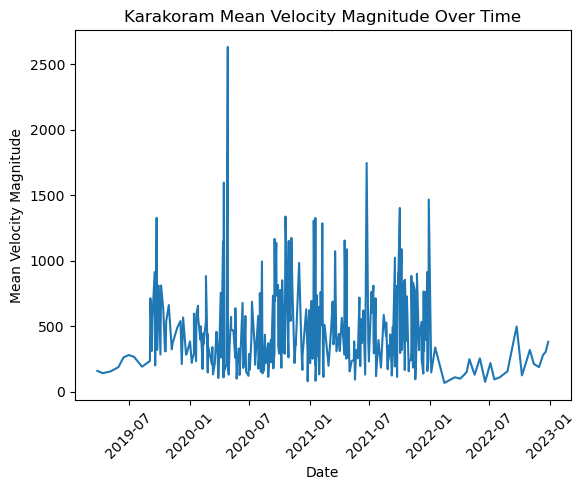

In [13]:
plt.plot(summary_df['midpoint'], summary_df['mean_vel_magnitude'])
plt.xticks(rotation=45) 
plt.xlabel('Date')
plt.ylabel('Mean Velocity Magnitude')
plt.title('Karakoram Mean Velocity Magnitude Over Time')
plt.show()

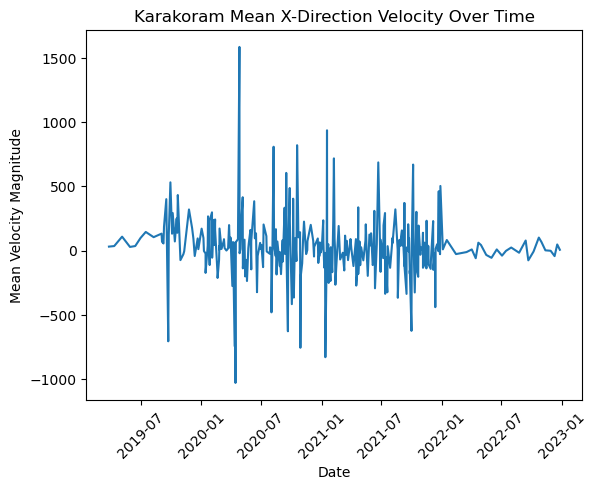

In [14]:
plt.plot(summary_df['midpoint'], summary_df['mean_vx'])
plt.xticks(rotation=45) 
plt.xlabel('Date')
plt.ylabel('Mean Velocity Magnitude')
plt.title('Karakoram Mean X-Direction Velocity Over Time')
plt.show()

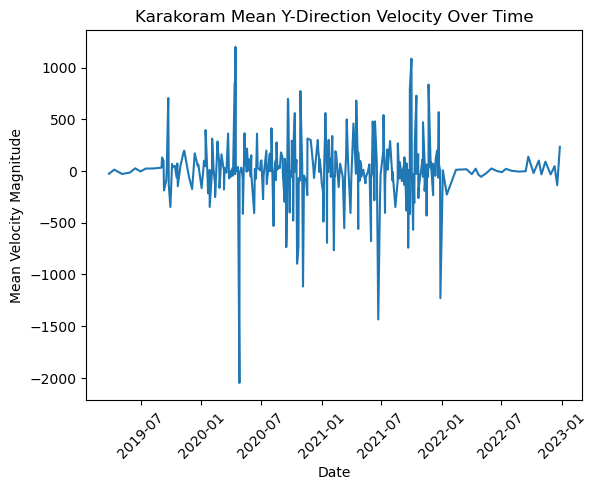

In [15]:
plt.plot(summary_df['midpoint'], summary_df['mean_vy'])
plt.xticks(rotation=45) 
plt.xlabel('Date')
plt.ylabel('Mean Velocity Magnitude')
plt.title('Karakoram Mean Y-Direction Velocity Over Time')
plt.show()

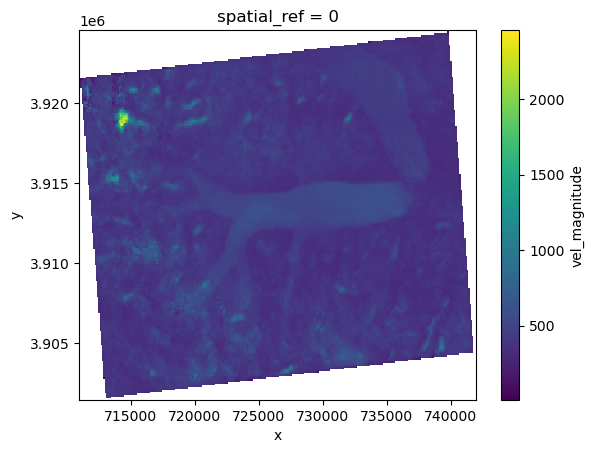

In [16]:
mean_vx_map = geotiffs_ds.x_vel.mean(dim='time')
mean_vy_map = geotiffs_ds.y_vel.mean(dim='time')
mean_speed_map = geotiffs_ds.vel_magnitude.mean(dim='time')

mean_speed_map.plot()

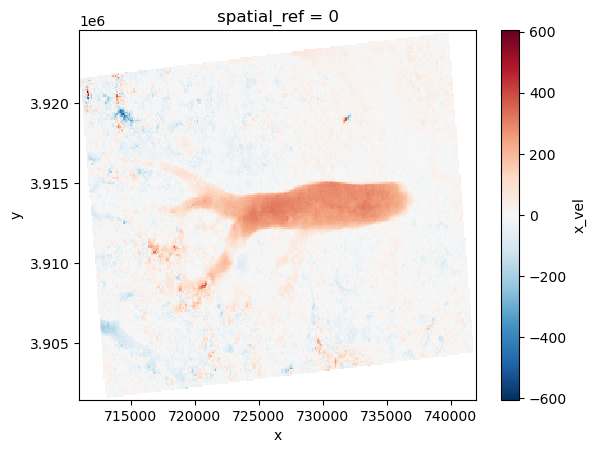

In [17]:
mean_vx_map.plot()

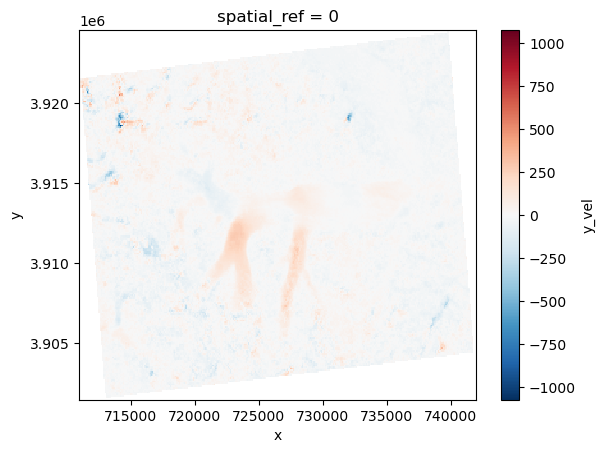

In [18]:
mean_vy_map.plot()

Looking at these plots we can see that the first two appear very similar; this indicates that magnitude of the velocity strongly matches the x velocity and that the effect of the velocity in the y direction is much less.

In [19]:
monthly = geotiffs_ds.groupby("mid_time.month").mean()

monthly_mean_vx = monthly.x_vel.mean(dim=['x','y'])
monthly_mean_vy = monthly.y_vel.mean(dim=['x','y'])
monthly_mean_speed = monthly.vel_magnitude.mean(dim=['x','y'])

monthly_summary = pd.DataFrame({
    'month': monthly.month.values,
    'monthly_mean_vx': monthly_mean_vx.values,
    'monthly_mean_vy': monthly_mean_vy.values,
    'monthly_mean_vel_magnitude': monthly_mean_speed.values})
monthly_summary

,month,monthly_mean_vx,monthly_mean_vy,monthly_mean_vel_magnitude
0,1,12.556101,-54.119293,464.159546
1,2,43.465866,-40.536942,434.080475
2,3,27.862223,4.903705,312.591797
3,4,-14.059546,20.990734,362.559692
4,5,22.491653,-33.337276,300.147583
5,6,23.547859,9.924263,324.959442
6,7,-26.748487,20.440420,393.433929
7,8,6.792795,15.999484,287.973114
8,9,31.421078,-17.597631,517.292603
9,10,16.477249,9.113063,532.711060


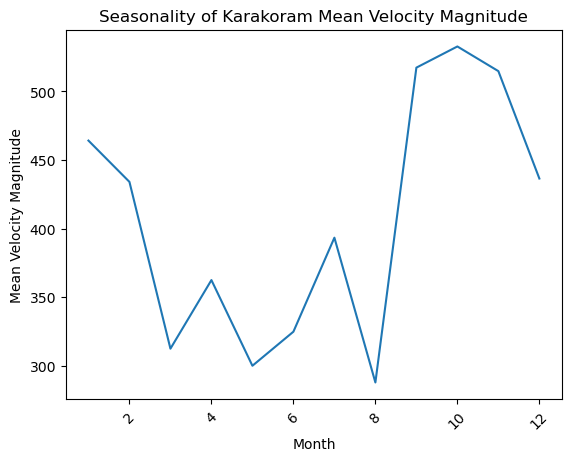

In [20]:
plt.plot(monthly_summary['month'], monthly_summary['monthly_mean_vel_magnitude'])
plt.xticks(rotation=45) 
plt.xlabel('Month')
plt.ylabel('Mean Velocity Magnitude')
plt.title('Seasonality of Karakoram Mean Velocity Magnitude')
plt.show()

This plot shows the seasonality of the Karakoram glacier's velocity.

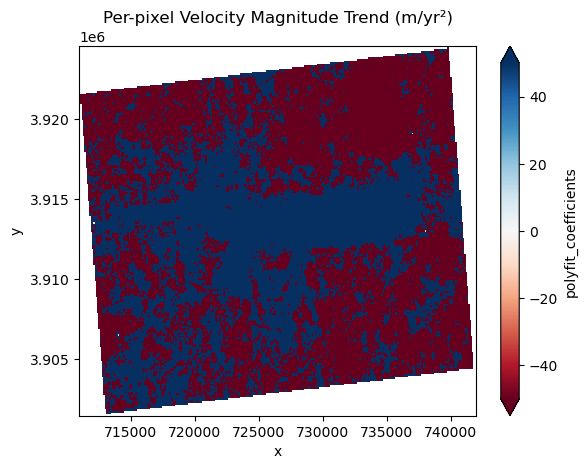

In [21]:
trend_map = geotiffs_ds.vel_magnitude.polyfit(dim="mid_time", deg=1)
slope_map = trend_map.polyfit_coefficients.sel(degree=0)
slope_map = slope_map * 365

slope_map.plot(cmap='RdBu', vmin=-50, vmax=50)
plt.title("Per-pixel Velocity Magnitude Trend (m/yr²)")
plt.show()

This figure shows the Karakoram's glacier acceleration; the blue(positive) indicates acceleration while the red(negative) indicates deceleration.